In [18]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta  # For technical indicators
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries installed and imported successfully!")


Libraries installed and imported successfully!


In [23]:
# set up API key here: https://www.alphavantage.co/support/#api-key

# Alpha Vantage API key (Replace with your key)
API_KEY = "818L0AZVDJ6XCXX7"

# Initialize Alpha Vantage TimeSeries API
ts = TimeSeries(key=API_KEY, output_format="pandas")

# Fetch 1-hour intraday data for SPY
# Change 'interval' to '1min' if you want minute-level data
symbol = "SPY"  # S&P 500 ETF
interval = "60min"  # Change to "1min" for minute data

# Get data from Alpha Vantage
df, meta_data = ts.get_intraday(symbol=symbol, interval=interval, outputsize="full")

# Rename columns for easier handling
df.columns = ["Open", "High", "Low", "Close", "Volume"]

# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Sort by time (oldest to newest)
df = df.sort_index()

# Display the first few rows
print(df.head())

# Save locally as CSV
df.to_csv("SPY_1hour_data.csv", index=True)


                       Open    High     Low   Close    Volume
date                                                         
2025-04-24 04:00:00  533.73  533.73  531.10  532.04   74339.0
2025-04-24 05:00:00  532.14  533.48  532.04  533.20  127711.0
2025-04-24 06:00:00  533.20  536.45  533.02  535.96  196029.0
2025-04-24 07:00:00  535.96  536.03  533.55  534.30  462107.0
2025-04-24 08:00:00  535.76  536.40  531.29  536.11  677985.0


In [24]:
# Compute Lagged Returns
df["Return"] = df["Close"].pct_change()

# Compute Exponential Moving Averages (EMA)
df["EMA_5"] = df["Close"].ewm(span=5, adjust=False).mean()
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()

# Compute Relative Strength Index (RSI)
df["RSI_14"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()

# Compute MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(df["Close"])
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()

# Compute On-Balance Volume (OBV)
df["OBV"] = ta.volume.OnBalanceVolumeIndicator(df["Close"], df["Volume"]).on_balance_volume()

# Compute Bollinger Bands
bb = ta.volatility.BollingerBands(df["Close"], window=20, window_dev=2)
df["BB_High"] = bb.bollinger_hband()
df["BB_Low"] = bb.bollinger_lband()

# Drop NaN values caused by indicator calculations
df = df.dropna()

# Display first few rows
print(df.head())


                       Open    High     Low   Close     Volume    Return  \
date                                                                       
2025-04-25 20:00:00  550.64  550.64  550.64  550.64  1571349.0 -0.001069   
2025-04-28 04:00:00  549.65  549.78  548.22  549.70    47499.0 -0.001707   
2025-04-28 05:00:00  549.78  550.62  549.37  550.04    27488.0  0.000619   
2025-04-28 06:00:00  550.11  550.11  548.82  549.02    43898.0 -0.001854   
2025-04-28 07:00:00  548.94  550.41  548.77  549.99   146216.0  0.001767   

                          EMA_5      EMA_10     RSI_14      MACD  MACD_Signal  \
date                                                                            
2025-04-25 20:00:00  550.644728  549.839271  67.870734  2.619426     2.663617   
2025-04-28 04:00:00  550.329819  549.813949  62.550387  2.441682     2.619230   
2025-04-28 05:00:00  550.233213  549.855049  63.660016  2.301721     2.555728   
2025-04-28 06:00:00  549.828808  549.703222  58.098405  2.0844

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define base feature columns
base_features = [
    "Return", "EMA_5", "EMA_10", "RSI_14", "MACD", "MACD_Signal", "OBV", "BB_High", "BB_Low"
]

# Create lagged features for each base feature (6 lags)
n_lags = 6
lagged_feature_columns = []

for feature in base_features:
    for lag in range(n_lags):
        col_name = f"{feature}_lag{lag}"
        df[col_name] = df[feature].shift(lag)
        lagged_feature_columns.append(col_name)

# Define the prediction target: next return (regression target)
df["Target"] = df["Return"].shift(-1)

# Drop rows with NaNs caused by shifting
df = df.dropna()

# Prepare features and target
X = df[lagged_feature_columns].values
y = df["Target"].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for LSTM input: [samples, time steps, features]
n_features = len(base_features)
X_lstm = X_scaled.reshape(-1, n_lags, n_features)

# Split into Train (80%) and Test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, shuffle=False)

# Print shapes
print(f"X_train shape: {X_train.shape}")  # should be (samples, 6, 9)
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (268, 6, 9)
X_test shape: (67, 6, 9)
y_train shape: (268,)
y_test shape: (67,)


Epoch 1/20


/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7141e-04 - val_loss: 2.6606e-04
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3086e-04 - val_loss: 2.2769e-04
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0518e-04 - val_loss: 6.3572e-05
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6457e-04 - val_loss: 1.3514e-04
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7423e-04 - val_loss: 6.4579e-05
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.4283e-05 - val_loss: 4.8498e-05
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2853e-05 - val_loss: 3.4688e-05
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8860e-05 - val_loss: 3.4439e-05
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8499e-05 - val_loss: 3.1180e-05
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3706e-05 - val_loss: 2.0144e-05
Epoch 12/20
8/8 ━━━━━━━━━━

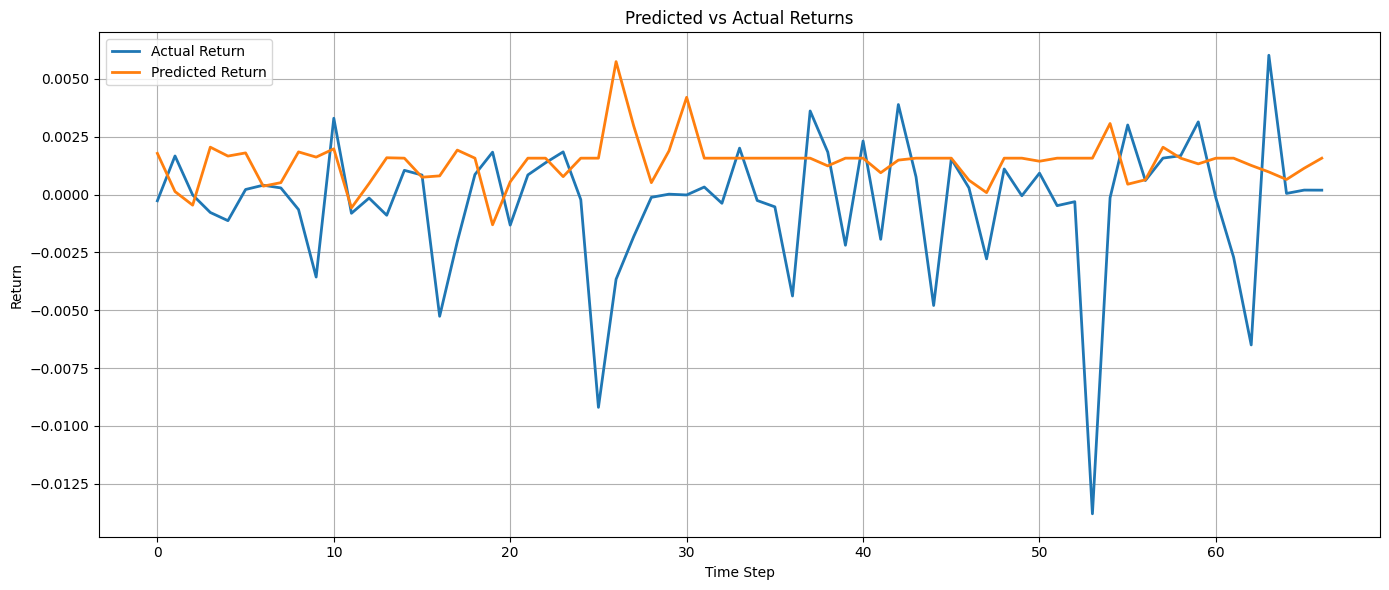

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Define LSTM regression model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(6, 9)),  # <-- 6 time steps, 9 features
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)  # regression output
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Predict
y_pred = model.predict(X_test).flatten()

# Plot predictions vs actual values
plt.figure(figsize=(14, 6))
plt.plot(y_test, label="Actual Return", linewidth=2)
plt.plot(y_pred, label="Predicted Return", linewidth=2)
plt.title("Predicted vs Actual Returns")
plt.xlabel("Time Step")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
X_train.shape  # should be (samples, 6, 9)


(268, 6, 9)

/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_14
Received: inputs=['Tensor(shape=(10, 6, 9))']
  warnings.warn(msg)
/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_14
Received: inputs=['Tensor(shape=(50, 6, 9))']
  warnings.warn(msg)


(10, 6, 9, 1)


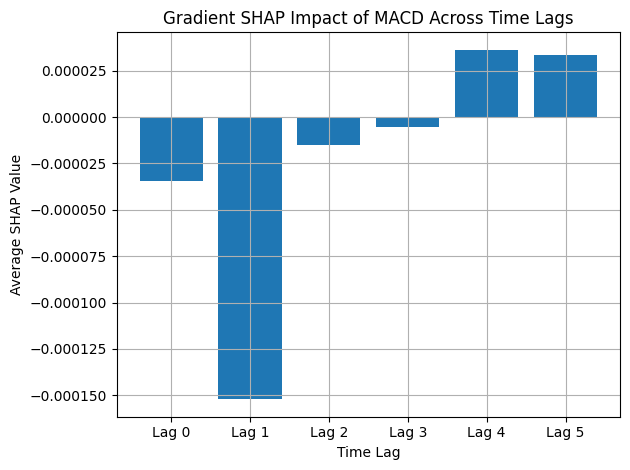

In [28]:
# 1. Install and import SHAP (only run once)
!pip install shap
import shap
import numpy as np
import matplotlib.pyplot as plt

# 2. Choose background dataset for SHAP (small sample of training data)
background = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

# 3. Initialize GradientExplainer using your trained model and the background
explainer = shap.GradientExplainer(model, background)

# 4. Explain a few test samples (e.g., first 10)
shap_values = explainer.shap_values(X_test[:10])  # returns a list, one per output

# 5. Inspect shape of SHAP values to confirm: [outputs, samples, time_steps, features]
print(np.array(shap_values).shape)
# Expected: (1, 10, 6, 9)

macd_index = 4  # MACD is the 5th feature (index 4)
macd_shap_across_lags = []

for lag in range(6):
    # Access [sample, lag, feature, output]
    values_at_lag = [shap_values[i, lag, macd_index, 0] for i in range(10)]
    macd_shap_across_lags.append(values_at_lag)

# Compute average SHAP value for MACD across 10 samples
mean_impact = np.mean(macd_shap_across_lags, axis=1)

# Plot
import matplotlib.pyplot as plt
plt.bar([f"Lag {i}" for i in range(6)], mean_impact)
plt.title("Gradient SHAP Impact of MACD Across Time Lags")
plt.xlabel("Time Lag")
plt.ylabel("Average SHAP Value")
plt.grid(True)
plt.tight_layout()
plt.show()



In [29]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [30]:
def compute_cash_attributions(model, X_input, baselines, steps=50):
    """
    Compute CASh (Context-Aware Shapley-weighted Gradients) attributions.

    Args:
        model (tf.keras.Model): Trained neural network model.
        X_input (np.ndarray): Input samples of shape [n_samples, time_steps, features].
        baselines (np.ndarray): Baseline samples of same shape to integrate from.
        steps (int): Number of interpolation steps between baseline and input.

    Returns:
        np.ndarray: CASh attributions with shape [n_samples, time_steps, features].
    """
    assert X_input.shape[1:] == baselines.shape[1:], "Baseline and input must match in shape."

    X_input = np.array(X_input).astype(np.float32)
    baselines = np.array(baselines).astype(np.float32)
    attributions = np.zeros_like(X_input)

    for b in baselines:
        for i, x in enumerate(X_input):
            # Generate interpolated inputs from baseline to input
            interpolated_inputs = tf.convert_to_tensor([
                b + (float(s) / steps) * (x - b) for s in range(steps + 1)
            ], dtype=tf.float32)

            with tf.GradientTape() as tape:
                tape.watch(interpolated_inputs)
                preds = model(interpolated_inputs)

            # Compute gradients of the prediction w.r.t. inputs
            grads = tape.gradient(preds, interpolated_inputs).numpy()

            # Average gradients and apply chain rule
            avg_grads = np.mean(grads, axis=0)
            diff = x - b
            attributions[i] += avg_grads * diff

    # Average across baselines
    return attributions / len(baselines)


In [31]:
# Choose 10 baseline sequences from training set
baseline_samples = X_train[np.random.choice(X_train.shape[0], 10, replace=False)]

# Select first 5 samples from test set
X_input_samples = X_test[:5]

# Compute CASh attributions
cash_attr = compute_cash_attributions(model, X_input_samples, baseline_samples)


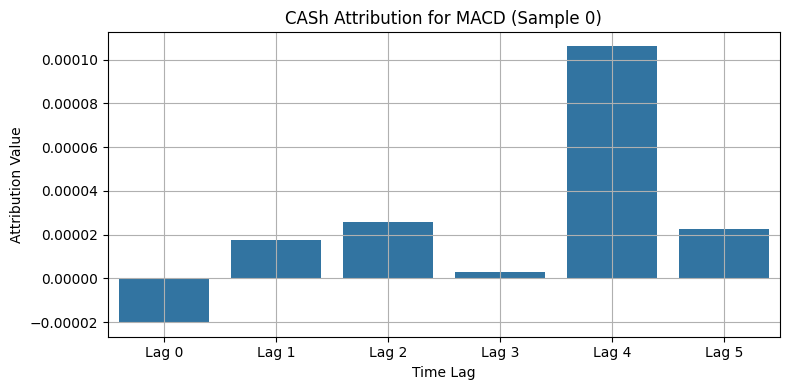

In [32]:
def plot_cash_attribution(attributions, feature_names, target_feature, sample_index=0):
    feature_index = feature_names.index(target_feature)
    values = attributions[sample_index, :, feature_index]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=[f"Lag {i}" for i in range(len(values))], y=values)
    plt.title(f"CASh Attribution for {target_feature} (Sample {sample_index})")
    plt.xlabel("Time Lag")
    plt.ylabel("Attribution Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot MACD
plot_cash_attribution(cash_attr, base_features, "MACD", sample_index=0)
